# Audio TTS Datasets

> TTS datasets

In [ ]:
#| default_exp audio.datasets.tts

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
import torch
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import LightningDataModule, LightningModule

from matplotlib import pyplot as plt

from lhotse import CutSet, RecordingSet, SupervisionSet, Fbank, FbankConfig
from lhotse.dataset import BucketingSampler, OnTheFlyFeatures
from lhotse.dataset.collation import TokenCollater
from lhotse.dataset.vis import plot_batch
from lhotse.recipes import download_librispeech, prepare_librispeech

from pathlib import Path
from pprint import pprint
from typing import List, Dict, Optional, Union

## Text-To-Speech

### Lhotse-based Base Class
https://github.com/Lightning-AI/lightning/issues/10358
https://colab.research.google.com/drive/1HKSYPsWx_HoCdrnLpaPdYj5zwlPsM3NH

In [ ]:
#| export
class LhotseTTSDataset(Dataset):
    def __init__(self,
                tokenizer=TokenCollater, # text tokenizer
                extractor=OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=80))) # feature extractor
                ):
        self.extractor = extractor
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "feats_lens": feat_lens, "tokens_pad": tokens, "tokens_lens": token_lens}

In [ ]:
# tok = TokenCollater()
# ds = LhotseTTSDataset(tok)

### Default base class

In [ ]:
#| export 
class TTSDataset(Dataset):
    def __init__(self,
        tokenizer, # text tokenizer
        num_mel_bins:int=80,  # number of mel spectrogram bins
        sampling_rate:int=16000 # sampling rate
        ):
        self.extractor = OnTheFlyFeatures(Fbank(FbankConfig(num_mel_bins=num_mel_bins, sampling_rate=sampling_rate)))
        self.tokenizer = tokenizer

    def __getitem__(self, cuts: CutSet) -> dict:
        cuts = cuts.sort_by_duration()
        feats, feat_lens = self.extractor(cuts)
        tokens, token_lens = self.tokenizer(cuts)
        return {"feats_pad": feats, "feats_lens": feat_lens, "tokens_pad": tokens, "tokens_lens": token_lens}

### LibriTTS DataModule

In [ ]:
#| export
from lhotse.recipes import download_libritts, prepare_libritts
from nimrod.text.tokenizers import Tokenizer
from nimrod.audio.embedding import EncoDec
from torchaudio.datasets import LIBRITTS
from nimrod.audio.utils import plot_waveform

ModuleNotFoundError: No module named 'nimrod'

In [ ]:
#(Waveform, Sample_rate, Original_text, Normalized_text, Speaker_ID, Chapter_ID, Utterance_ID)
ds = LIBRITTS("../data/en", 'test-clean')
print(ds[0])


(tensor([[0.0007, 0.0008, 0.0012,  ..., 0.0039, 0.0042, 0.0042]]), 24000, 'He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour-fattened sauce. Stuff it into you, his belly counselled him.', 'He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick peppered flour fattened sauce. Stuff it into you, his belly counselled him.', 1089, 134686, '1089_134686_000001_000001')


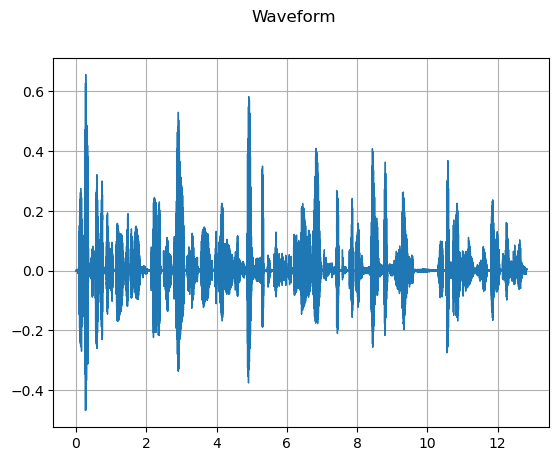

In [ ]:
plot_waveform(ds[0][0], ds[0][1])

In [ ]:
#| export
class LibriTTSDataModule(LightningDataModule):
    def __init__(self,
        target_dir="/data/en/libriTTS", # where data will be saved / retrieved
        dataset_parts=["dev-clean", "test-clean"], # either full libritts or subset
        output_dir="/home/syl20/slg/nimrod/recipes/libritts/data", # where to save manifest
        num_jobs=0 # num_jobs depending on number of cpus available
    ):
        super().__init__()
        self.save_hyperparameters(logger=False)

    def prepare_data(self,) -> None:
        # takes a while to download from openslr mirror (~15 min each for test/dev-clean)
        download_libritts(target_dir=self.hparams.target_dir, dataset_parts=self.hparams.dataset_parts)

    def setup(self, stage = None):
        self.libri = prepare_libritts(corpus_dir=Path(self.hparams.target_dir) / "LibriTTS", output_dir=self.hparams.output_dir, num_jobs=self.hparams.num_jobs)
        if stage == 'fit' or stage == None:
            self.cuts_train = CutSet.from_manifests(**self.libri["dev-clean"])
            self.cuts_test = CutSet.from_manifests(**self.libri["test-clean"])
            self.tokenizer = TokenCollater(self.cuts_train)
            self.tokenizer(self.cuts_test.subset(first=2))
            # self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))
        if stage == "test":
            self.cuts_test = CutSet.from_manifests(**self.libri["test-clean"])
            self.tokenizer = TokenCollater(self.cuts_test)
            self.tokenizer(self.cuts_test.subset(first=2))
            # self.tokenizer.inverse(*self.tokenizer(self.cuts_test.subset(first=2)))

    def train_dataloader(self):
        train_sampler = BucketingSampler(self.cuts_train, max_duration=300, shuffle=True) #, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer, sampling_rate=24000), sampler=train_sampler, batch_size=None, num_workers=self.hparams.num_jobs)

    def test_dataloader(self):
        test_sampler = BucketingSampler(self.cuts_test, max_duration=400, shuffle=False) #, bucket_method="equal_duration")
        return DataLoader(TTSDataset(self.tokenizer, sampling_rate=24000), sampler=test_sampler, batch_size=None, num_workers=self.hparams.num_jobs)

    @property
    def model_kwargs(self):
        return {
            "odim": len(self.tokenizer.idx2token),
        }

### Usage

In [ ]:
# num_jobs=0 turns parallel computing off within jupyter notebook. Else it fails.
dm = LibriTTSDataModule(
    target_dir="../data/en", 
    dataset_parts="test-clean",
    output_dir="../data/en/LibriTTS/test-clean",
    num_jobs=1
)

NameError: name 'LibriTTSDataModule' is not defined

In [ ]:
# skip download and use local data folder
# dm.prepare_data()

In [ ]:
dm.setup(stage='test')

Preparing LibriTTS parts: 100%|██████████| 7/7 [00:00<00:00, 8169.21it/s]


In [ ]:
test_dl = dm.test_dataloader()
batch = next(iter(test_dl))
print(batch.keys())

dict_keys(['feats_pad', 'feats_lens', 'tokens_pad', 'tokens_lens'])


torch.Size([4, 1515, 80])
tensor([1515, 1478, 1464, 1299])
tensor([ 2, 30, 43, 40,  4, 54, 40, 49, 55, 40, 49, 38, 40,  4, 50, 41,  4, 54,
        36, 44, 49, 55,  4, 45, 36, 48, 40, 54,  4, 58, 43, 44, 38, 43,  4, 54,
        36, 60, 54,  4, 55, 43, 36, 55,  4, 43, 40,  4, 58, 43, 50,  4, 50, 41,
        41, 40, 49, 39, 54,  4, 36, 42, 36, 44, 49, 54, 55,  4, 50, 49, 40,  4,
        38, 50, 48, 48, 36, 49, 39, 48, 40, 49, 55,  4, 37, 40, 38, 50, 48, 40,
        54,  4, 42, 56, 44, 47, 55, 60,  4, 50, 41,  4, 36, 47, 47,  7,  4, 43,
        36, 39,  4, 54, 40, 40, 48, 40, 39,  4, 55, 50,  4, 43, 44, 48,  4, 41,
        44, 53, 54, 55,  4, 36,  4, 54, 58, 50, 47, 47, 40, 49,  4, 51, 43, 53,
        36, 54, 40,  4, 56, 49, 55, 44, 47,  4, 43, 40,  4, 43, 36, 39,  4, 37,
        40, 42, 56, 49,  4, 55, 50,  4, 42, 53, 50, 51, 40,  4, 44, 49,  4, 55,
        43, 40,  4, 39, 36, 53, 46, 49, 40, 54, 54,  4, 50, 41,  4, 43, 44, 54,
         4, 50, 58, 49,  4, 54, 55, 36, 55, 40,  9,  3,  0,  

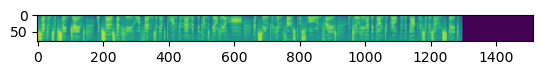

In [ ]:
print(batch['feats_pad'].shape)
plt.imshow(batch['feats_pad'][3].transpose(0,1))
print(batch['feats_lens'])
print(batch['tokens_pad'][3], batch['tokens_lens'][3])

In [ ]:
original_sentences = dm.tokenizer.inverse(batch['tokens_pad'], batch['tokens_lens'])
print(original_sentences)

["A certain pride, a certain awe, withheld him from offering to God even one prayer at night, though he knew it was in God's power to take away his life while he slept and hurl his soul hellward ere he could beg for mercy.", 'It was strange too that he found an arid pleasure in following up to the end the rigid lines of the doctrines of the church and penetrating into obscure silences only to hear and feel the more deeply his own condemnation.', 'He had sinned mortally not once but many times and he knew that, while he stood in danger of eternal damnation for the first sin alone, by every succeeding sin he multiplied his guilt and his punishment.', 'The sentence of saint james which says that he who offends against one commandment becomes guilty of all, had seemed to him first a swollen phrase until he had begun to grope in the darkness of his own state.']


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()